In [4]:
from numba import cuda, njit, vectorize, prange
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.signal as signal

# define some functions

In [95]:
def present_signal(sig, fs, color='b', title=''):
    fsig, psig = signal.periodogram(sig,fs=fs)
    
    fig,ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(title)
    ax[0].plot(sig,color=color)
    ax[0].set_title('signal')
    ax[0].set_xlabel('samples')
    ax[0].set_ylabel('amplitude [a.u.]')
    
    
    ax[1].semilogy(fsig*1e-6, psig/np.max(psig),color=color)
    ax[1].set_title('power spectrum')
    ax[1].set_xlabel('frequency [MHz]')
    ax[1].set_ylabel('amplitude [a.u.]')
    
    plt.tight_layout()

# load some data

In [9]:
data = loadmat('./data/sim_single_cyst.mat')
print(data.keys())

fs = np.squeeze(data['fs']) # sampling frequency
fs = np.float64(fs)
c = np.squeeze(data['c']) # speed of sound
# when c is uint16 it raise error, thus it should be casted into proper type
c = np.float64(c)

pitch = np.squeeze(data['pitch']) # pitch
angles = np.squeeze(data['angles']) # transmit angles

rf = np.squeeze(data['rf']) # radio-frequency (rf) data acquired by probe elements
rf = np.transpose(rf,(2,1,0))
# decimation - the fs=1e8 is not necessary high
dec = 4
rf = signal.decimate(rf, dec)
fs = fs/dec

print(f'sampling frequency [MHz]: {fs*1e-6}')

dict_keys(['__header__', '__version__', '__globals__', 'angles', 'c', 'fc', 'fs', 'pitch', 'rf', 'rfrc'])
sampling frequency [MHz]: 25.0


# FIR filter implementation - 1D

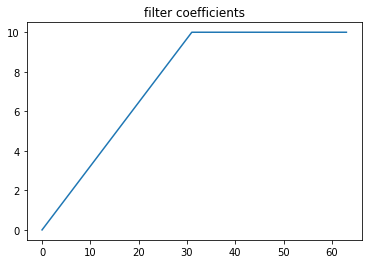

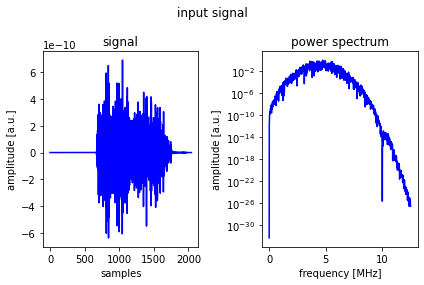

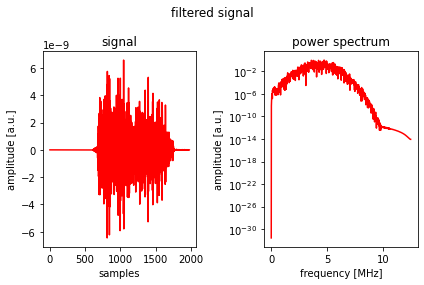

In [96]:
sig = rf[0,0,:]






ntaps = 32
w = np.concatenate((np.linspace(0,10,ntaps),
                    np.linspace(10,10,ntaps)))


fig,ax = plt.subplots(nrows=1, ncols=1)
ax.plot(w)
ax.set_title('filter coefficients')

# allocation
sigflt = np.zeros(sig.size - w.size)


for i in range(sigflt.size):
    sigflt[i] = np.sum(sig[i:i+w.size]*w[::-1])
#     print(sigflt[i])


present_signal(sig, fs, 'blue', 'input signal')
present_signal(sigflt, fs, 'red', 'filtered signal')


    
# fsigflt, psigflt = signal.periodogram(sigflt,fs=fs)


# fig,ax = plt.subplots(nrows=2, ncols=2)
# ax[0,0].plot(sig)
# ax[0,0].set_title('input signal')
# ax[0,1].semilogy(fsig, psig/np.max(psig))
# ax[0,1].set_title('input signal power spectrum')
# plt.tight_layout()

# ax[1,0].plot(sigflt)
# ax[1,0].set_title('filtered signal')
# ax[1,1].semilogy(fsigflt, psigflt/np.max(psigflt))
# ax[1,1].set_title('filtered signal power spectrum')
# plt.tight_layout()
    
